# Atividade 03 - Parte 01

## Modelagem de Dispersão

- Implementar uma função para determinar a classe de estabilidade de Pasquil para diferentes condições atmosféricas.

- Implementar a função de estimativa de coefiente de dispersão (sigmaYZ) para todas as classes de estabilidade.

- Implementar a função de estimativa de sobrelevação da pluma utilizando os métodos de Davidson-Bryant, Holland e Briggs (quem fizer o método de Briggs ganha um ponto a mais). Deve ser considerado o efeito Tip-Downwash

- Implementar a função do modelo gaussiano

- Realizar simulações com o script criado, utilizando diferentes classes de estabilidade, velocidades do vento, alturas de chaminé. Considere a taxa de emissão que você estimou na primeira atividade. Encontre a altura de chaminé necessária para que as concentrações não violem os padrões da Resolução CONAMA 491.

- Faça figuras e discuta os resultados.

## Implementar função para determinar classes de estabilidade de Pasquill 

Utilizando o EZ-AERMOD foram importados dados de diferentes condições atmosférias e classificando conforme estação do ano. Posteriormente foi implementada a classificação de estabilidade de Pasqui conforme faixas de valores forncidadas pela universidade Federal do Espírito Santo.


In [141]:
import os
import pandas as pd

# Função para determinar a classe de estabilidade
def determinar_classe_estabilidade(row):
    u = row['u (m/s)']
    FCS = row['FCS (W/m2)']
    cco = row['cco']
    
    # Verificar se FCS é numérico
    if pd.isna(FCS) or not isinstance(FCS, (int, float)):
        return 'Unknown'  # ou qualquer valor padrão desejado
    
    FCS = float(FCS)  # Converte para float se não for
    
    if u < 2:
        if FCS > 700:
            return 'A'
        elif 350 <= FCS <= 700:
            return 'A - B'
        elif FCS < 350:
            return 'B'
    elif 2 <= u < 3:
        if FCS > 700:
            return 'A - B'
        elif 350 <= FCS <= 700:
            return 'B'
        elif FCS > 350:
            return 'C'
        if cco >= 4:
            return 'E'
        elif cco <= 3:
            return 'F'
    elif 3 <= u < 5:
        if FCS > 700:
            return 'B'
        elif 350 <= FCS <= 700:
            return 'B - C'
        elif FCS < 350:
            return 'C'
        if cco >= 4:
            return 'D'
        elif cco <= 3:
            return 'E'
    elif 5 <= u <= 6:
        if FCS > 700:
            return 'C'
        elif 350 <= FCS <= 700:
            return 'C - D'
        elif FCS < 350:
            return 'D'
        if cco >= 4:
            return 'D'
        elif cco <= 3:
            return 'D'
    elif u > 6:
        if FCS > 700:
            return 'C'
        elif 350 <= FCS <= 700:
            return 'D'
        elif FCS < 350:
            return 'D'
        if cco >= 4:
            return 'D'
        elif cco <= 3:
            return 'D'

## Testanto implementação para diferentes condições atmosféricas 

In [142]:
# Pegando o caminho do diretório que estou
rootPath = os.getcwd()
print(rootPath)

# Definindo o diretório com os arquivos metar
meteoSFC = os.path.join(rootPath, 'inputs', 'meteoSFC')
print(meteoSFC)

# Listando os arquivos dentro do diretório
files = os.listdir(meteoSFC)
print(files)

# Nome das colunas que desejamos importar
columns = ['year', 'month', 'day', 'hour', 'FCS (W/m2)', 'u (m/s)', 'cco']

# Abrindo cada arquivo dentro da pasta e acumulando em uma lista chamada de metSFC
metSFC = []
for file in files:
    file_path = os.path.join(meteoSFC, file)
    df = pd.read_csv(file_path, usecols=columns)
    
    # Convertendo FCS (W/m2) para numérico
    df['FCS (W/m2)'] = pd.to_numeric(df['FCS (W/m2)'], errors='coerce')
    
    metSFC.append(df)

# Convertendo metSFC para DataFrame
metSFC = pd.concat(metSFC, ignore_index=True)

# Criando a coluna datetime
metSFC['datetime'] = pd.to_datetime(metSFC[['year', 'month', 'day', 'hour']])

# Aplicando a função para classificar as estações
metSFC['estacao'] = metSFC['datetime'].apply(classify_season)

# Aplicando a função para determinar a classe de estabilidade
metSFC['classe_estabilidade'] = metSFC.apply(determinar_classe_estabilidade, axis=1)

# Exibindo o DataFrame final
print(metSFC)


C:\ENS5173_MayaraDargas\ENS5173-2024.1_MayaraDargasSousa
C:\ENS5173_MayaraDargas\ENS5173-2024.1_MayaraDargasSousa\inputs\meteoSFC
['meteo.sfc.csv']
      year  month  day  hour  FCS (W/m2)  u (m/s)  cco            datetime  \
0     2023      1    1     1       -34.5      4.1    6 2023-01-01 01:00:00   
1     2023      1    1     2       -32.2      4.1    6 2023-01-01 02:00:00   
2     2023      1    1     3       -37.2      4.6    6 2023-01-01 03:00:00   
3     2023      1    1     4       -42.0      5.1    6 2023-01-01 04:00:00   
4     2023      1    1     5       -12.5      2.6    6 2023-01-01 05:00:00   
...    ...    ...  ...   ...         ...      ...  ...                 ...   
8757  2023     12   31    22        -9.2      2.1    6 2023-12-31 22:00:00   
8758  2023     12   31    23      -999.0    999.0    6 2023-12-31 23:00:00   
8759  2023     12   31    24      -999.0    999.0    6 2024-01-01 00:00:00   
8760  2023     12   31    24      -999.0    999.0    6 2024-01-01 00:00:

## Gráfico 

In [143]:
def determinar_estacao(mes):
    if mes in [12, 1, 2]:  # Dezembro, Janeiro, Fevereiro -> Verão
        return 'Verão'
    elif mes in [3, 4, 5]:  # Março, Abril, Maio -> Outono
        return 'Outono'
    elif mes in [6, 7, 8]:  # Junho, Julho, Agosto -> Inverno
        return 'Inverno'
    elif mes in [9, 10, 11]:  # Setembro, Outubro, Novembro -> Primavera
        return 'Primavera'
    else:
        return 'Desconhecido'

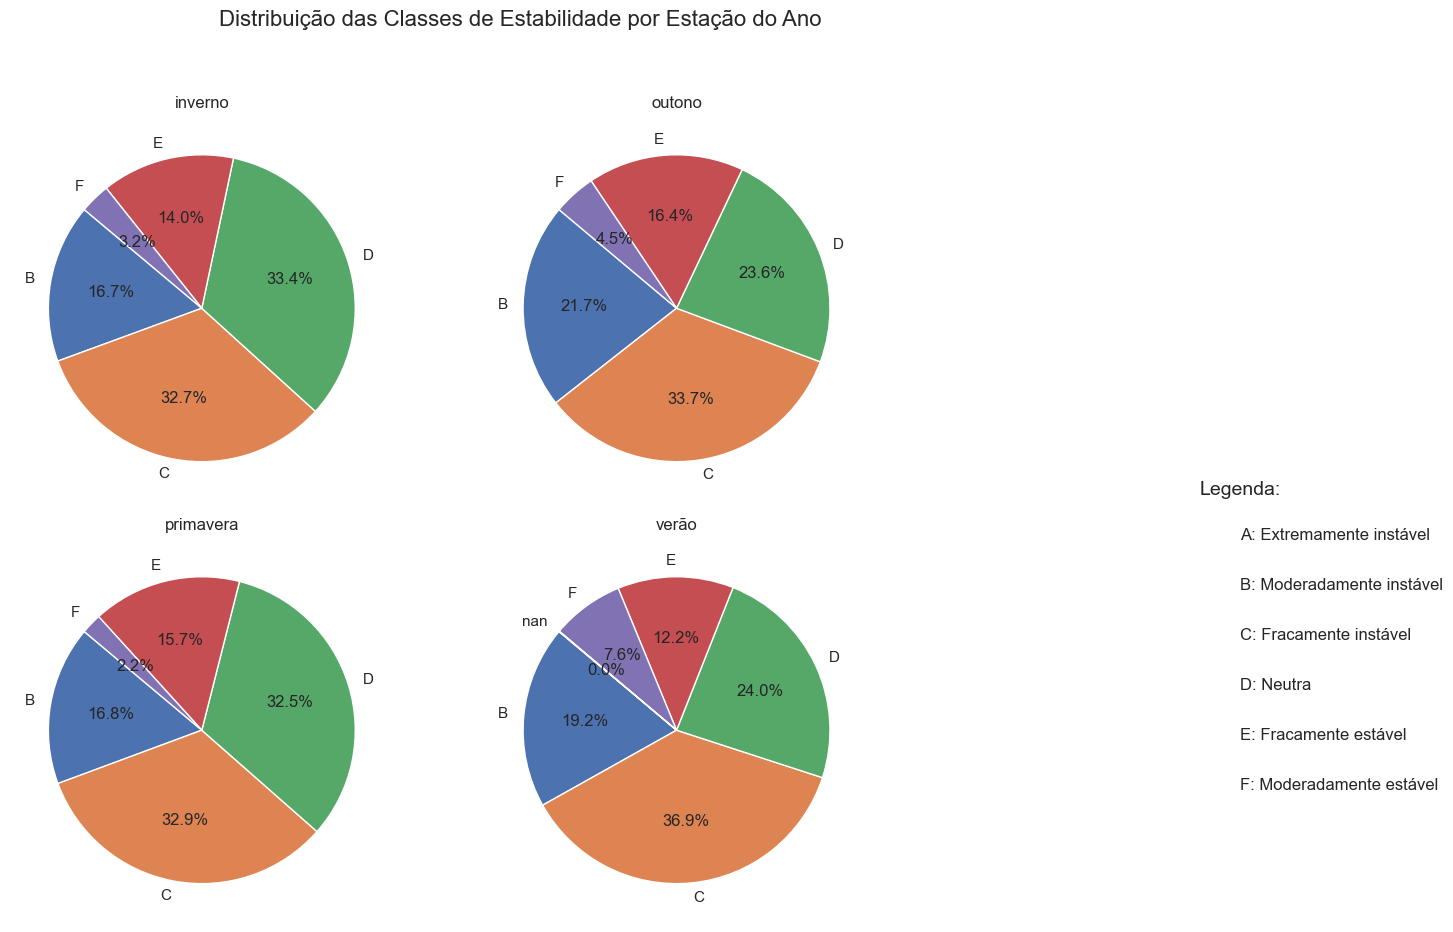

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Supondo que 'metSFC' seja seu DataFrame com os dados

# Agrupando por estação do ano e classe de estabilidade
estacoes_classes = metSFC.groupby(['estacao', 'classe_estabilidade']).size().reset_index(name='count')

# Reordenando as classes de estabilidade para exibição no gráfico
classes_ordem = ['A', 'A - B', 'B', 'B - C', 'C', 'C - D', 'D', 'E', 'F']
estacoes_classes['classe_estabilidade'] = pd.Categorical(estacoes_classes['classe_estabilidade'], categories=classes_ordem, ordered=True)

# Criando os gráficos de pizza
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Iterando sobre cada estação do ano
for ax, (estacao, data) in zip(axes.flatten(), estacoes_classes.groupby('estacao')):
    labels = data['classe_estabilidade']
    sizes = data['count']
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    ax.set_title(estacao)

# Ajustando a posição da legenda
legend_text = {
    'A': 'Extremamente instável',
    'B': 'Moderadamente instável',
    'C': 'Fracamente instável',
    'D': 'Neutra',
    'E': 'Fracamente estável',
    'F': 'Moderadamente estável'
}

# Exibindo as informações da legenda
plt.figtext(1.1, 0.5, 'Legenda:', ha='center', fontsize=14, va='center')
for i, (key, value) in enumerate(legend_text.items()):
    plt.figtext(1.1, 0.45 - i*0.05, f'{key}: {value}', ha='left', fontsize=12)

# Ajustes de layout
plt.suptitle('Distribuição das Classes de Estabilidade por Estação do Ano', fontsize=16)
plt.tight_layout(rect=[0, 0.05, 0.9, 0.95])  # Ajuste do espaço para a legenda
plt.subplots_adjust(right=0.85)  # Ajuste para acomodar a legenda
plt.show()


## Implementar a função de estimativa de coefiente de dispersão (sigmaYZ) para todas as classes de estabilidade

In [158]:
import pandas as pd

# Função para calcular sigmaY e sigmaZ com base nos parâmetros
def sigmaYZ(x, classe, urbOrRural):
    if urbOrRural == 'urbano':
        if classe == 'A-B':
            sigmaY = 0.32 * x * (1 + 0.0004 * x) ** (-0.5)
            sigmaZ = 0.24 * x * (1 + 0.001 * x) ** 0.5
        elif classe == 'C':
            sigmaY = 0.22 * x * (1 + 0.0004 * x) ** (-0.5)
            sigmaZ = 0.20 * x
        elif classe == 'D':
            sigmaY = 0.16 * x * (1 + 0.0004 * x) ** (-0.5)
            sigmaZ = 0.14 * x * (1 + 0.0003 * x) ** (-0.5)
        elif classe == 'E-F':
            sigmaY = 0.11 * x * (1 + 0.0004 * x) ** (-0.5)
            sigmaZ = 0.08 * x * (1 + 0.0015 * x) ** (-0.5)
        else:
            raise ValueError('Classe de estabilidade errada')
    elif urbOrRural == 'rural':
        if classe == 'A':
            sigmaY = 0.22 * x * (1 + 0.0001 * x) ** (-0.5)
            sigmaZ = 0.20 * x
        elif classe == 'B':
            sigmaY = 0.16 * x * (1 + 0.0001 * x) ** (-0.5)
            sigmaZ = 0.12 * x
        elif classe == 'C':
            sigmaY = 0.11 * x * (1 + 0.0001 * x) ** (-0.5)
            sigmaZ = 0.08 * x * (1 + 0.0002 * x) ** (-0.5)
        elif classe == 'D':
            sigmaY = 0.08 * x * (1 + 0.0001 * x) ** (-0.5)
            sigmaZ = 0.06 * x * (1 + 0.0003 * x) ** (-0.5)
        elif classe == 'E':
            sigmaY = 0.06 * x * (1 + 0.0001 * x) ** (-0.5)
            sigmaZ = 0.03 * x * (1 + 0.0003 * x) ** (-1)
        elif classe == 'F':
            sigmaY = 0.04 * x * (1 + 0.0001 * x) ** (-0.5)
            sigmaZ = 0.016 * x * (1 + 0.0003 * x) ** (-1)
        else:
            raise ValueError('Classe de estabilidade errada')
    else:
        raise ValueError('Tipo de ambiente deve ser "urbano" ou "rural"')
    
    return sigmaY, sigmaZ

## Testando implementação para todas as classes de estabilidade

In [ ]:

# Valores de x para calcular
x_values = [100, 1000, 10000]
environments = ['urbano', 'rural']
classes_urbano = ['A-B', 'C', 'D', 'E-F']
classes_rural = ['A', 'B', 'C', 'D', 'E', 'F']

# Lista para armazenar os resultados
results = []

# Calculando sigmaY e sigmaZ para cada combinação de x, classe e ambiente
for x in x_values:
    for environment in environments:
        if environment == 'urbano':
            classes = classes_urbano
        elif environment == 'rural':
            classes = classes_rural
        
        for classe in classes:
            sigmaY, sigmaZ = sigmaYZ(x, classe, environment)
            results.append({'x': x, 'classe': classe, 'environment': environment, 'sigmaY': sigmaY, 'sigmaZ': sigmaZ})

# Convertendo os resultados para um DataFrame
df_results = pd.DataFrame(results)

# Exibindo a tabela com os resultados
print(df_results)


## Implementar a função de estimativa de sobrelevação da pluma

## Efeito Tip-Downwash

In [200]:
#determinar a tendência da pluma a ser dirigida em direção ao solo junto a chaminédef Holland(vs, d, u, p, Ts, Tamb):
def hg_tip_downwash(hg, d, vs, u):
    hg2 = hg + (2*d * ((vs/u)-1.5))
    return hg2

### Método de Davidson-Bryant

In [201]:
# Função para estimar o deltaH com base na equação de Davidson-Bryant

def DavidsonBryant(d, vs, u, Ts, Tamb):
    deltaH_DavidsonBryant = (d*(vs/u)**(1.4))*(1+(Ts-Tamb)/Ts)
    return DavidsonBryant

# d: diâmetro da chaminé (m)
# vs: velocidade do efluente na saída da chaminé (m/s)
# u: velocidade do vento a 10 metros (m/s)
# deltaT: temperatura do gás na chaminé menos a tempeatura ambiente (K)
# Ts: Tempetarura do gás na saída da chaminé (K)
# Tamb: Temperatura ambiente

### Método de Holland 

In [202]:
# Função para estimar o deltaH com base na equação de Holland

def Holland(vs, d, u, p, Ts, Tamb):
    deltaH_Holland = (vs*d/u)*(1.5+(2.68*10**-3)*(p*((Ts-Tamb)/Ts)*d))
    return Holland

# Se condições atmosféricas instáveis fazer acréscimo de 10-20% de delta H em delta H (se classe igual a A acrescentar 20%, se classe iguaal a B acrestar 15% e se classe igual a C acrescentar 10%)
# Se forem estáveis, diminui-se igual quantidade (Se classe igual a E diminui 10% e se classe igual a F diminui 20%)

### Método de Briggs 

In [205]:
import math

# Constante pi
pi = math.pi  

# Função para calcular a vazão volumétrica (Qo)
def vazao_volumetrica(rc, vs):
    Qo = pi * (rc**2) * vs
    return Qo

# Função para calcular o parâmetro de flutuabilidade (Fb)
def flutuabilidade(Qo, Tamb, Ts):
    Fb = (9.8 / pi) * Qo * (1 - (Tamb / Ts))
    return Fb

# Função para calcular o gradiente de temperatura potencial
def grad_temp_potencial(G, classe):
    if classe == 'A':
        G = -0.020
    elif classe == 'B':
        G = -0.018
    elif classe == 'C':
        G = -0.016
    elif classe == 'D':
        G = -0.010
    elif classe == 'E':
        G = 0.005
    else:
        G = 0.028
    grad = G - (-0.0098)
    return grad

# Função para calcular o índice de estabilidade (S)
def indice_de_estabilidade(Tamb, d_theta, d_z):
    S = (9.8 / Tamb) * (d_theta / d_z)
    return S

# Função para calcular o fluxo momentâneo
def fluxo_momentaneo(vs, d, Tamb, Ts):
    Fm = (vs**2) * (d**2) * (Tamb / (4 * Ts))
    return Fm

# g: aceleração da gravidade (9,8 m²/s)
# deltaT: temperatura do gás na chaminé menos a tempeatura ambiente (K)
# Ts: Tempetarura do gás na saída da chaminé (K)
# Tamb: Temperatura ambiente
# rc: raio da chaminé (m)
# vs: velocidade do efluente na saída da chaminé (m/s)
# G: Valor médio do gradiente de temperatura ambiente


# Função principal de Briggs
def Briggs(Fb, vs, d, u, hg2, deltaT, deltaTc, S, classe, Ts):
    
    # Determinar se a atmosfera é instável ou estável com base na classe de Pasquill
    tipo_atmosfera = 'instavel' if classe in ['A', 'B', 'C', 'D'] else 'estavel'

    if tipo_atmosfera == 'instavel':
        if Fb < 55:
            deltaTc = 0.0297 * Ts * (vs**(1/3) / (d**(2/3)))
            if deltaTc > deltaT:
                H = hg2 + 3 * d * (vs / u)
            else:
                H = hg2 + (21.425 * ((Fb**(3/4)) / u))
        elif Fb >= 55:
            deltaTc = 0.00575 * Ts * (vs**(2/3) / (d**(1/3)))
            if deltaTc > deltaT:
                H = hg2 + 3 * d * (vs / u)
            else:
                H = hg2 + (2.6 * ((Fb / u)**(1/3)))
    
    if tipo_atmosfera == 'estavel':
        deltaTc = 0.01958 * Ts * vs * (S**(1/2))
        if deltaT < deltaTc:
            H = hg2 + 3 * d * (vs / u)
        else:
            H = hg2 + (2.6 * ((Fb**(3/4)) / u))
    
    return H


## Altura efetiva da pluma

In [187]:
#Altura efetiva DavidsonBryant
#Altura efetiva Holand
#Altura efetiva Briggs

In [177]:
# Gerar 5 valores aleatórios para cada parâmetro usando distribuições específicas
num_samples = 1

random.seed(42)  # Para reproduzibilidade dos resultados

# Gerar listas de valores aleatórios para cada parâmetro
d_values = [random.uniform(0.1, 1.0) for _ in range(num_samples)]  # diâmetro da chaminé (m)
vs_values = [random.normalvariate(10.0, 2.0) for _ in range(num_samples)]  # velocidade do efluente (m/s)
u_values = [random.normalvariate(5.0, 1.0) for _ in range(num_samples)]  # velocidade do vento a 10m (m/s)
Ts_values = [random.uniform(400.0, 500.0) for _ in range(num_samples)]  # temperatura do gás na saída (K)
Tamb_values = [random.uniform(280.0, 310.0) for _ in range(num_samples)]  # temperatura ambiente (K)

# Calcular os resultados usando a função DavidsonBryant para cada conjunto de valores
results = []
for i in range(num_samples):
    d = d_values[i]
    vs = vs_values[i]
    u = u_values[i]
    Ts = Ts_values[i]
    Tamb = Tamb_values[i]
    deltaH = DavidsonBryant(d, vs, u, Ts, Tamb)
    results.append({
        'd (m)': d,
        'vs (m/s)': vs,
        'u (m/s)': u,
        'Ts (K)': Ts,
        'Tamb (K)': Tamb,
        'deltaH (resultado)': deltaH
    })

# Criar um DataFrame do Pandas para apresentar os resultados em forma de tabela
df_results = pd.DataFrame(results)

# Mostrar a tabela com os resultados
print("Resultados da função DavidsonBryant com valores aleatórios usando o método de Monte Carlo:")
print(df_results)

Resultados da função DavidsonBryant com valores aleatórios usando o método de Monte Carlo:
      d (m)  vs (m/s)   u (m/s)      Ts (K)    Tamb (K)  deltaH (resultado)
0  0.675484  7.752027  3.198149  467.669949  306.765387            3.135853


## Implementar a função do Modelo Gaussiano 

In [188]:
def modeloGaussiano(qs,sigmaY,sigmaZ,u,y,z,H):
    termo1 = qs/(2*np.pi*sigmaY*sigmaZ*u)
    termo2 = np.exp((-y**2)/(2*sigmaY**2))
    termo3 = np.exp((-(z-H)**2)/(2*sigmaZ**2)) + np.exp((-(z+H)**2)/(2*sigmaZ**2))
    conc = termo1*termo2*termo3
    conc = conc*10**6
    return conc